# Proyek Kedua Machine Learning Terapan - Recommendation System
- **Nama:** Nabilah Wanara
- **Email:** 	mc006d5x211p@student.devacademy.id
- **ID Dicoding:** MC006D5X2119

# Import Library dan Setup

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nabilahwanara","key":"9b07444ef34e60b9ab3e8c83b1cc9c7e"}'}

In [ ]:
os.makedirs('/root/.kaggle', exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Data Loading

In [ ]:
#Download dataset dari Kaggle
!kaggle datasets download -d meirnizri/cellphones-recommendations

!unzip -q cellphones-recommendations.zip -d cellphones-recommendations

Dataset URL: https://www.kaggle.com/datasets/meirnizri/cellphones-recommendations
License(s): ODbL-1.0
cellphones-recommendations.zip: Skipping, found more recently modified local copy (use --force to force download)
replace cellphones-recommendations/cellphones data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace cellphones-recommendations/cellphones ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace cellphones-recommendations/cellphones users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [ ]:
def load_data(folder_path):
    data_file = os.path.join(folder_path, 'cellphones data.csv')
    users_file = os.path.join(folder_path, 'cellphones users.csv')
    ratings_file = os.path.join(folder_path, 'cellphones ratings.csv')

    products = pd.read_csv(data_file)
    users = pd.read_csv(users_file)
    ratings = pd.read_csv(ratings_file)

    return products, users, ratings

In [ ]:
folder_path = 'cellphones-recommendations'
products, users, ratings = load_data(folder_path)

# Data Understanding

Tujuan tahap ini adalah:

- Melihat info awal data.

In [ ]:
def dataset_info(df, name):
    print(f"Dataset: {name}")
    print(f"{'='*50}")
    print(f"Shape   : {df.shape}")
    print(f"Columns : {df.columns.tolist()}\n")

    print("nfo:")
    print(df.info())

    print("\nFirst 10 Rows:")
    print(df.head(10))
    print()

In [ ]:
dataset_info(products, "Products")

Dataset: Products
Shape   : (33, 14)
Columns : ['cellphone_id', 'brand', 'model', 'operating system', 'internal memory', 'RAM', 'performance', 'main camera', 'selfie camera', 'battery size', 'screen size', 'weight', 'price', 'release date']

nfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     

In [ ]:
dataset_info(users, "Users")

Dataset: Users
Shape   : (99, 4)
Columns : ['user_id', 'age', 'gender', 'occupation']

nfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     99 non-null     int64 
 1   age         99 non-null     int64 
 2   gender      99 non-null     object
 3   occupation  98 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB
None

First 10 Rows:
   user_id  age  gender         occupation
0        0   38  Female       Data analyst
1        1   40  Female  team worker in it
2        6   55  Female                 IT
3        8   25  Female            Manager
4       10   23    Male             worker
5       12   28  Female         Accountant
6       16   31  Female              sales
7       24   57  Female                 it
8       25   27  Female        Team leader
9       26   28  Female            FINANCE



In [ ]:
dataset_info(ratings, "Ratings")

Dataset: Ratings
Shape   : (990, 3)
Columns : ['user_id', 'cellphone_id', 'rating']

nfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       990 non-null    int64
 1   cellphone_id  990 non-null    int64
 2   rating        990 non-null    int64
dtypes: int64(3)
memory usage: 23.3 KB
None

First 10 Rows:
   user_id  cellphone_id  rating
0        0            30       1
1        0             5       3
2        0            10       9
3        0             9       3
4        0            23       2
5        0             8       2
6        0            22       1
7        0            16       2
8        0            19       1
9        0             3      10



# Exploratory Data Analysis (EDA)

In [ ]:
def describe(df, name):
    print(f"Statistik Deskriptif: {name}")
    print(df.describe())
    print()

In [ ]:
describe(products, "Products")

Statistik Deskriptif: Products
       cellphone_id  internal memory        RAM  performance  main camera  \
count      33.00000        33.000000  33.000000    33.000000    33.000000   
mean       16.00000       148.363636   6.787879     6.219091    41.333333   
std         9.66954        92.197417   2.712904     2.885472    26.350601   
min         0.00000        32.000000   3.000000     1.020000    12.000000   
25%         8.00000       128.000000   4.000000     3.800000    12.000000   
50%        16.00000       128.000000   8.000000     6.880000    50.000000   
75%        24.00000       128.000000   8.000000     7.940000    50.000000   
max        32.00000       512.000000  12.000000    11.000000   108.000000   

       selfie camera  battery size  screen size      weight        price  
count      33.000000     33.000000    33.000000   33.000000    33.000000  
mean       15.484848   4320.666667     6.433333  197.363636   628.272727  
std        10.028463    818.746590     0.476095   

In [ ]:
describe(users, "Users")

Statistik Deskriptif: Users
          user_id        age
count   99.000000  99.000000
mean   136.373737  36.393939
std     81.034206   9.678314
min      0.000000  21.000000
25%     76.500000  29.500000
50%    128.000000  33.000000
75%    220.500000  42.000000
max    258.000000  61.000000



In [ ]:
describe(ratings, "Ratings")

Statistik Deskriptif: Ratings
          user_id  cellphone_id      rating
count  990.000000    990.000000  990.000000
mean   136.373737     16.421212    6.700000
std     80.664654      9.473466    2.639036
min      0.000000      0.000000    1.000000
25%     74.000000      8.000000    5.000000
50%    128.000000     16.000000    7.000000
75%    226.000000     25.000000    9.000000
max    258.000000     32.000000   18.000000



1. **Statistik Deskriptif: Products**
  
  * Internal memory berkisar antara 32–512 GB, dengan rata-rata 148 GB.

  * RAM rata-rata sekitar 6.8 GB, minimum 3 GB dan maksimum 12 GB.

  * Main camera dan selfie camera memiliki variasi besar, dengan kamera utama tertinggi mencapai 108 MP.

  * Battery size rata-rata 4320 mAh, menunjukkan sebagian besar ponsel memiliki baterai besar.
  * Screen size umumnya berkisar antara 4.7 hingga 7.6 inci.

  * Price bervariasi cukup besar, dengan rata-rata 628 USD dan maksimum hampir 2000 USD.


2.  **Statistik Deskriptif: Users**

  * Terdapat 99 pengguna, dengan usia antara 21 hingga 61 tahun.

  * Usia rata-rata pengguna adalah sekitar 36 tahun, menunjukkan dominasi usia produktif.


3.  **Statistik Deskriptif: Ratings**

  * Terdapat 990 data rating yang diberikan pengguna terhadap ponsel.

  * Rating berkisar dari 1 hingga 18, dengan rata-rata sekitar 6.7.

  * Distribusi rating menunjukkan nilai tengah di angka 7, dan mayoritas rating berada di rentang 5 hingga 9.

**Visualisasi Fitur**

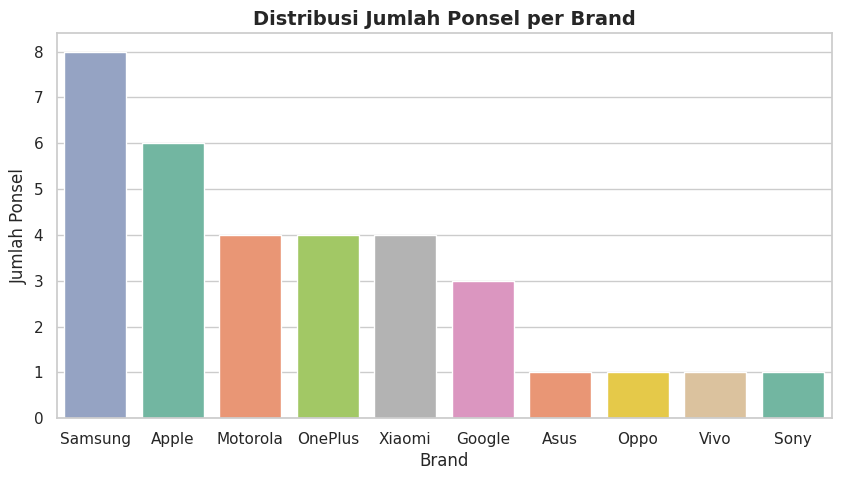

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))

# Distribusi Jumlah Ponsel per Brand
brand_counts= products['brand'].value_counts()

sns.countplot(data=products, x='brand', hue='brand', order=brand_counts.index, palette='Set2', legend=False)
plt.title('Distribusi Jumlah Ponsel per Brand', fontsize=14, fontweight='bold')
plt.xlabel("Brand")
plt.ylabel("Jumlah Ponsel")
plt.show()

Dari **10** brand yang ada, Samsung memiliki **8** model ponsel paling banyak, disusul Apple dengan **6** model. Sementara itu, Asus, Oppo, Vivo, dan Sony tercatat hanya memiliki **1** model ponsel masing-masing.

In [ ]:
# Mengelompokkan model berdasarkan brand
models_by_brand = products.groupby('brand')['model'].apply(list).to_dict()

# Menghitung jumlah total model
total_models = sum(len(models) for models in models_by_brand.values())
print('Jumlah model ponsel:', total_models)

print("\nDaftar model berdasarkan brand:")
for brand, models in models_by_brand.items():
    print(f"\nBrand: {brand}")
    for model in models:
        print(f"- {model}")

Jumlah model ponsel: 33

Daftar model berdasarkan brand:

Brand: Apple
- iPhone SE (2022)
- iPhone 13 Mini
- iPhone 13
- iPhone 13 Pro
- iPhone 13 Pro Max
- iPhone XR

Brand: Asus
- Zenfone 8

Brand: Google
- Pixel 6  
- Pixel 6a
- Pixel 6 Pro 

Brand: Motorola
- Moto G Stylus (2022)
- Moto G Play (2021)
- Moto G Pure
- Moto G Power (2022)

Brand: OnePlus
- Nord N20
- Nord 2T
- 10 Pro
- 10T

Brand: Oppo
- Find X5 Pro

Brand: Samsung
- Galaxy A13
- Galaxy A32
- Galaxy A53
- Galaxy S22
- Galaxy S22 Plus
- Galaxy S22 Ultra
- Galaxy Z Flip 3
- Galaxy Z Fold 3

Brand: Sony
- Xperia Pro

Brand: Vivo
- X80 Pro

Brand: Xiaomi
- Redmi Note 11
- 11T Pro
- 12 Pro
- Poco F4


Terdapat total **33** model ponsel yang berasal dari seluruh brand yang ada.


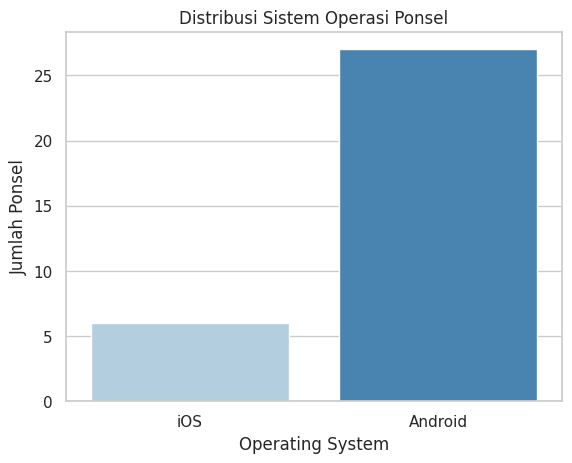

In [ ]:
# Menghitung jumlah operating system
os_counts = products['operating system'].value_counts()

# Distribusi Sistem Operasi Ponsel
sns.countplot(data=products, x='operating system', palette='Blues', legend=False)
plt.title("Distribusi Sistem Operasi Ponsel")
plt.xlabel("Operating System")
plt.ylabel("Jumlah Ponsel")
plt.show()

Grafik tersebut menunjukkan bahwa sebagian besar model ponsel menggunakan sistem operasi **Android**, dengan total sebanyak 27 perangkat. Sementara itu, hanya 6 perangkat yang menggunakan sistem operasi **iOS**.

Jumlah Internal Memory:
 internal memory
128    20
256     6
64      3
32      3
512     1
Name: count, dtype: int64 

Jumlah RAM:
 RAM
8     13
4      6
6      6
3      4
12     4
Name: count, dtype: int64 



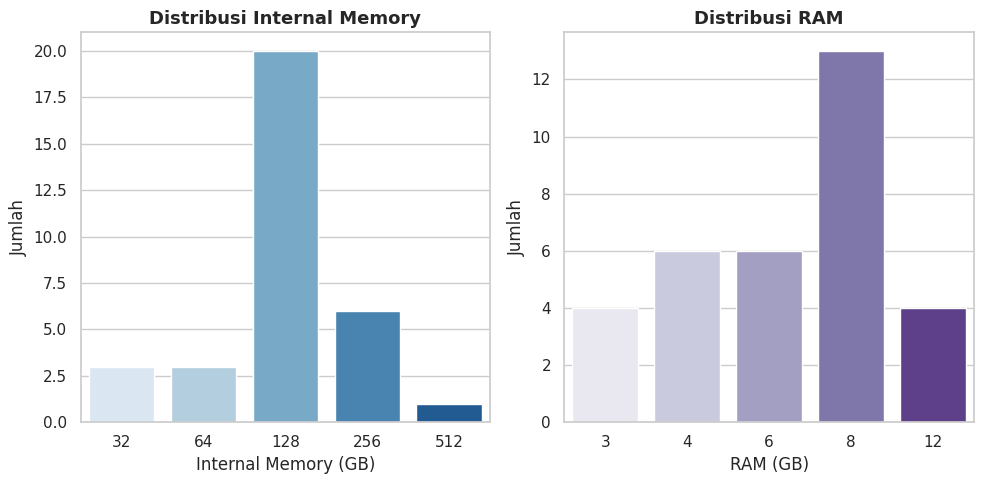

In [ ]:
def plot_memory_and_ram(data):
    print("Jumlah Internal Memory:\n", data['internal memory'].value_counts(), "\n")
    print("Jumlah RAM:\n", data['RAM'].value_counts(), "\n")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot Internal Memory
    sns.countplot(ax=axes[0], data=data, x='internal memory', palette='Blues')
    axes[0].set_title("Distribusi Internal Memory", fontsize=13, fontweight='bold')
    axes[0].set_xlabel("Internal Memory (GB)")
    axes[0].set_ylabel("Jumlah")

    # Plot RAM
    sns.countplot(ax=axes[1], data=data, x='RAM', palette='Purples')
    axes[1].set_title("Distribusi RAM", fontsize=13, fontweight='bold')
    axes[1].set_xlabel("RAM (GB)")
    axes[1].set_ylabel("Jumlah")

    plt.tight_layout()
    plt.show()

plot_memory_and_ram(products)

Grafik tersebut menunjukkan sebagian besar perangkat yang tersedia dilengkapi dengan memori internal sebesar **128 GB** sebanyak **20 perangkat**, serta **RAM 8 GB** yang digunakan pada **13 perangkat**.


In [ ]:
min_performance = products['performance'].min()
max_performance = products['performance'].max()
print(f"Rentang nilai performance: {min_performance} - {max_performance}\n")

Rentang nilai performance: 1.02 - 11.0



In [ ]:
# Memisahkan produk berdasarkan ambang batas performance
performance_high = products[products['performance'] > 5]
performance_low = products[products['performance'] <= 5]

# Menghitung total data untuk masing-masing kategori
total_high = len(performance_high)
total_low = len(performance_low)

# Menampilkan total produk untuk masing-masing kategori
print("Total ponsel dengan performa tinggi:", total_high)
print("Total ponsel dengan performa rendah:", total_low)

Total ponsel dengan performa tinggi: 23
Total ponsel dengan performa rendah: 10


In [ ]:
# Menyiapkan data untuk visualisasi
performance_summary = pd.DataFrame({
    'Category': ['High', 'Low'],
    'Total': [total_high, total_low]})

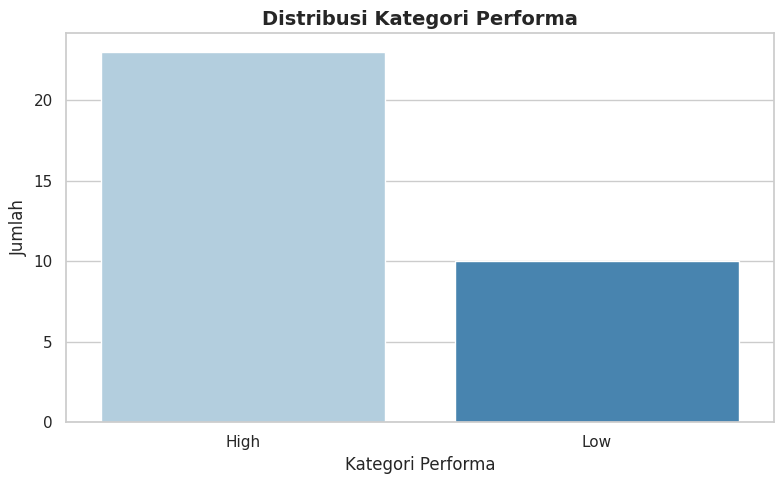

In [ ]:
# Membuat grafik batang dengan warna menarik
plt.figure(figsize=(8, 5))
barplot = sns.barplot(data=performance_summary, x='Category', y='Total', palette='Blues')

plt.title("Distribusi Kategori Performa", fontsize=14, fontweight='bold')
plt.xlabel("Kategori Performa")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

Rentang nilai performa berkisar antara 1,02 hingga 11,0, dengan kategori performa rendah untuk nilai di bawah 5 dan performa tinggi untuk nilai di atas 5. Grafik tersebut memperlihatkan bahwa dari total perangkat, terdapat 23 unit dengan performa tinggi dan 10 unit dengan performa rendah berdasarkan hasil pengujian menggunakan AnTuTu.


In [ ]:
# Menampilkan rentang nilai harga
min_price = products['price'].min()
max_price = products['price'].max()
print(f"Rentang harga: {min_price} - {max_price}\n")

Rentang harga: 129 - 1998



In [ ]:
# Membuat kategori harga: Entry Level, Mid Level, Flagship
price_bins = [0, 300, 800, max_price + 1]
price_labels = ['Entry Level (0-300 USD)', 'Mid Level (301-800 USD)', 'Flagship (>800 USD)']
products['price_category'] = pd.cut(products['price'], bins=price_bins, labels=price_labels, include_lowest=True)


In [ ]:
# Menghitung jumlah ponsel di setiap kategori harga
category_counts = products['price_category'].value_counts().sort_index()
print("Jumlah ponsel per kategori harga:")
print(category_counts)

Jumlah ponsel per kategori harga:
price_category
Entry Level (0-300 USD)     8
Mid Level (301-800 USD)    16
Flagship (>800 USD)         9
Name: count, dtype: int64


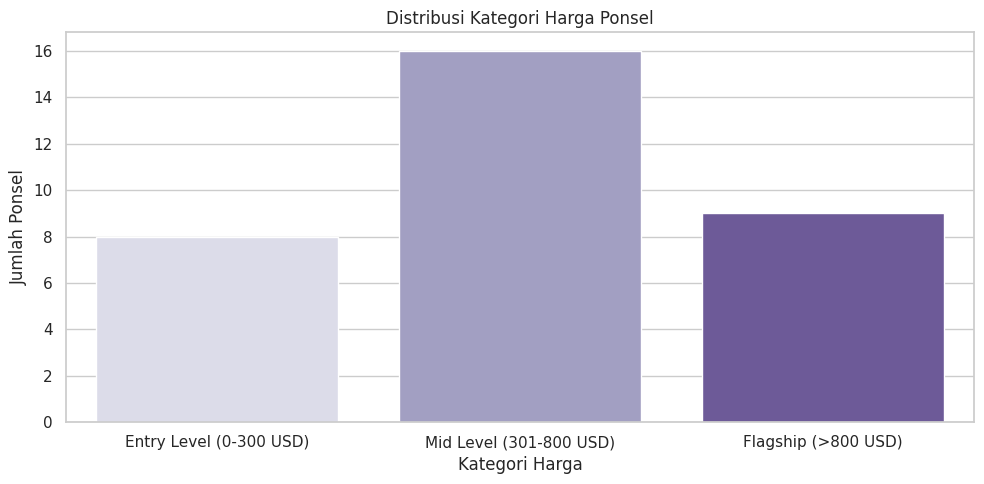

In [ ]:
# Distribusi kategori harga
plt.figure(figsize=(10, 5))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='Purples')
plt.title("Distribusi Kategori Harga Ponsel")
plt.xlabel("Kategori Harga")
plt.ylabel("Jumlah Ponsel")
plt.tight_layout()
plt.show()

Dari grafik tersebut, jumlah ponsel berdasarkan kategori harga menunjukkan bahwa terdapat **8** perangkat pada kategori Entry Level (0-300 USD), **16** perangkat pada kategori Mid Level (301-800 USD), dan **9** perangkat pada kategori Flagship dengan harga di atas 800 USD.

In [ ]:
user_review_counts = ratings['user_id'].value_counts()

print("Analisis Review User: ")
print("\nJumlah review per user:")
print(user_review_counts.describe())  # Statistik ringkas (count, mean, std, min, max, dll)

unique_review_counts = user_review_counts.unique()
print(f"\nNilai unik jumlah review per user: {unique_review_counts}")

if len(unique_review_counts) == 1:
    print(f"Semua user melakukan jumlah review yang sama: {unique_review_counts[0]} review per user.")
else:
    print(f"User dengan review terbanyak: {user_review_counts.max()} review")
    print(f"User dengan review paling sedikit: {user_review_counts.min()} review")
    print(f"Rata-rata review per user: {user_review_counts.mean():.2f}")

Analisis Review User: 

Jumlah review per user:
count    99.0
mean     10.0
std       0.0
min      10.0
25%      10.0
50%      10.0
75%      10.0
max      10.0
Name: count, dtype: float64

Nilai unik jumlah review per user: [10]
Semua user melakukan jumlah review yang sama: 10 review per user.


**Analisis Ulasan Pengguna:**

* Setiap pengguna memberikan jumlah ulasan yang sama, yakni sebanyak 10 ulasan.

In [ ]:
# Hitung jumlah review untuk tiap tipe ponsel
cellphone_review_counts = ratings['cellphone_id'].value_counts().reset_index()
cellphone_review_counts.columns = ['cellphone_id', 'review_count']

cellphone_reviews = cellphone_review_counts.merge(
    products[['cellphone_id', 'model']],
    on='cellphone_id',
    how='left'
)

In [ ]:
min_reviews = cellphone_review_counts['review_count'].min()
max_reviews = cellphone_review_counts['review_count'].max()
avg_reviews = cellphone_review_counts['review_count'].mean()

print("Analisis Review per Tipe Ponsel: ")
print(f"Ponsel dengan review paling sedikit: {min_reviews} review")
print(f"Ponsel dengan review paling banyak: {max_reviews} review")
print(f"Rata-rata jumlah review per ponsel: {avg_reviews:.2f}")

Analisis Review per Tipe Ponsel: 
Ponsel dengan review paling sedikit: 20 review
Ponsel dengan review paling banyak: 41 review
Rata-rata jumlah review per ponsel: 30.00


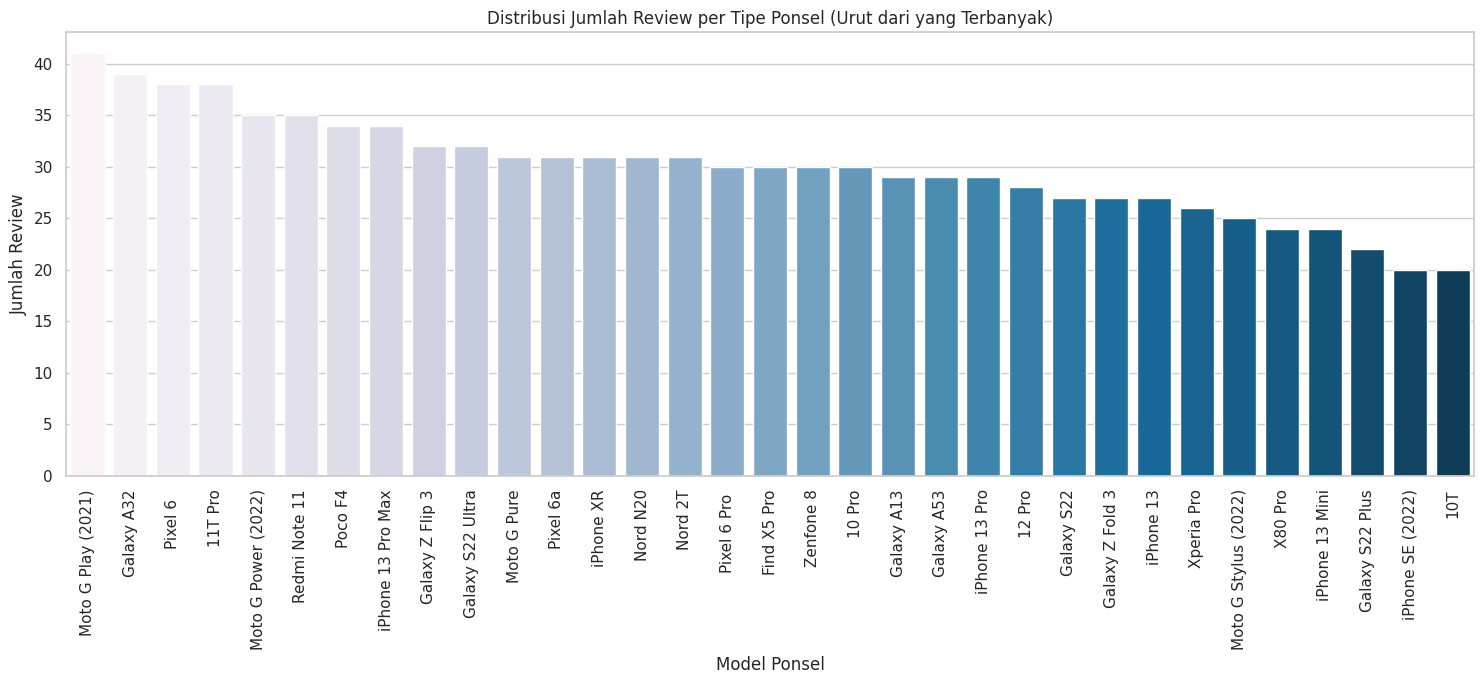

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(x='model', y='review_count', data=cellphone_reviews.sort_values('review_count', ascending=False),
            palette='PuBu')
plt.title("Distribusi Jumlah Review per Tipe Ponsel (Urut dari yang Terbanyak)")
plt.xlabel("Model Ponsel")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Analisis Ulasan Ponsel:**

* Ponsel dengan jumlah ulasan terbanyak adalah **Moto G Play (2021)** dengan **41** ulasan, sementara ponsel dengan ulasan paling sedikit adalah **iPhone SE (2022)** dan **10T**, masing-masing menerima **20** ulasan.

In [ ]:
# Hitung distribusi rating
rating_counts = ratings['rating'].value_counts().sort_index()

# Statistik rating
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()
mean_rating = ratings['rating'].mean()

print("Analisis Distribusi Rating: ")
print(f"Rating terkecil: {min_rating}")
print(f"Rating terbesar: {max_rating}")
print(f"Rata-rata rating: {mean_rating:.2f}")

Analisis Distribusi Rating: 
Rating terkecil: 1
Rating terbesar: 18
Rata-rata rating: 6.70


In [ ]:
# Deteksi kemungkinan outlier rating (nilai di luar rentang umum 1-10)
if max_rating > 10 or min_rating < 1:
    print("Terdapat nilai rating yang mencurigakan (outliers) dalam data.")

Terdapat nilai rating yang mencurigakan (outliers) dalam data.


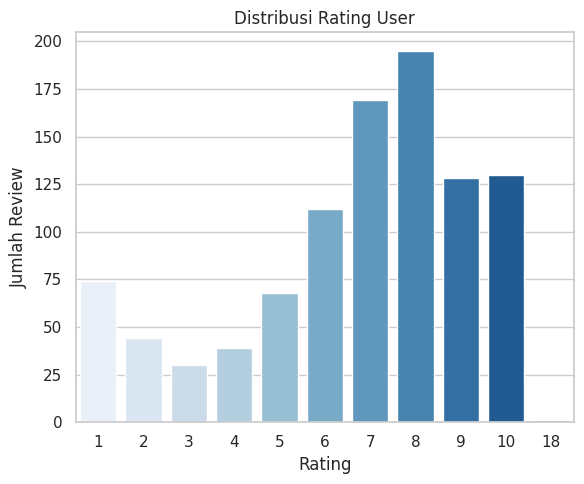

In [ ]:
# Visualisasi distribusi rating
plt.figure(figsize=(6, 5))
sns.countplot(x='rating', data=ratings, palette='Blues')
plt.title("Distribusi Rating User")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.tight_layout()
plt.show()

**Analisis Distribusi Rating:**

* Nilai rating berkisar antara 1 hingga 10. Rating yang paling sering muncul adalah nilai 8 dengan **195** kemunculan, sedangkan rating yang paling jarang diberikan adalah nilai 3 dengan **30** kemunculan. Selain itu, terdapat outlier pada nilai rating sebesar 18.

In [ ]:
# Hitung frekuensi kemunculan setiap usia dan tampilkan secara terurut
age_counts = users['age'].value_counts().sort_index()

In [ ]:
# Tampilkan rentang usia pengguna
min_age = users['age'].min()
max_age = users['age'].max()
most_common_age = age_counts.idxmax()
most_common_age_count = age_counts.max()

print("Analisis Usia Pengguna: ")
print(f"Usia termuda: {min_age}")
print(f"Usia tertua: {max_age}")
print(f"Usia yang paling banyak muncul: {most_common_age} (sebanyak {most_common_age_count} pengguna)")

Analisis Usia Pengguna: 
Usia termuda: 21
Usia tertua: 61
Usia yang paling banyak muncul: 25 (sebanyak 12 pengguna)


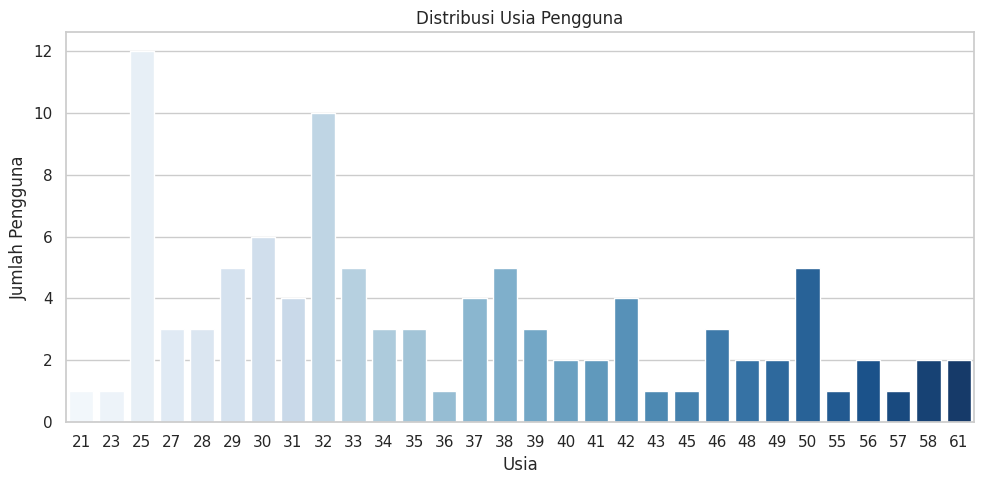

In [ ]:
# Visualisasi distribusi usia
plt.figure(figsize=(10, 5))
sns.countplot(data=users, x='age', palette='Blues')
plt.title("Distribusi Usia Pengguna")
plt.xlabel("Usia")
plt.ylabel("Jumlah Pengguna")
plt.tight_layout()
plt.show()

Grafik menunjukkan mayoritas pengguna berusia 25–35 tahun, dengan puncak pada usia 25 (12 pengguna). Usia termuda adalah 21 dan tertua 61. Ini menunjukkan dominasi pengguna usia muda, yang penting dipertimbangkan dalam sistem rekomendasi.

Analisis Gender Pengguna: 
Terdapat data invalid berupa pilihan '-Select Gender-' yang perlu dibersihkan.


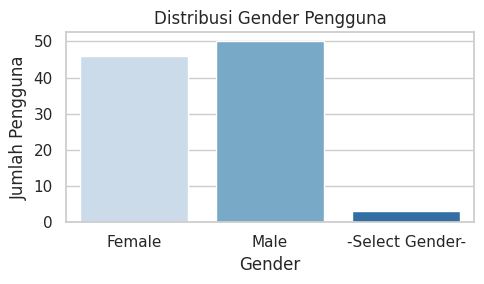

In [ ]:
# Hitung jumlah setiap kategori gender dan tampilkan
gender_counts = users['gender'].value_counts().sort_index()
print("Analisis Gender Pengguna: ")

if '-Select Gender-' in gender_counts.index:
    print("Terdapat data invalid berupa pilihan '-Select Gender-' yang perlu dibersihkan.")

plt.figure(figsize=(5, 3))
sns.countplot(data=users, x='gender', palette='Blues')
plt.title("Distribusi Gender Pengguna")
plt.xlabel("Gender")
plt.ylabel("Jumlah Pengguna")
plt.tight_layout()
plt.show()

Grafik menunjukkan distribusi gender pengguna didominasi oleh **laki-laki (50 pengguna)** dan **perempuan (45 pengguna)**. Terdapat juga beberapa entri tidak valid atau kosong **(label "-Select Gender-")** sebanyak **4 pengguna**. Data ini penting untuk memastikan sistem rekomendasi bersifat inklusif terhadap seluruh gender.

In [ ]:
# Hitung jumlah kemunculan tiap jenis pekerjaan (case insensitive)
occupation_counts = users['occupation'].str.lower().value_counts().sort_index()
print("Analisis Pekerjaan Pengguna: ")
print(f"Jumlah kategori pekerjaan unik: {len(occupation_counts)}")
print("Frekuensi pekerjaan pengguna:")
print(occupation_counts)

# Deteksi kesalahan penulisan umum pada pekerjaan
if 'healthare' in occupation_counts.index:
    print("\nDitemukan kesalahan penulisan pada 'healthare', yang benar adalah 'healthcare'.")

# Identifikasi pekerjaan yang bisa digabungkan untuk analisis yang lebih rapi
if 'information technology' in occupation_counts.index and 'it' in occupation_counts.index:
    print("Pekerjaan dengan kategori 'information technology' dan 'it' dapat digabungkan menjadi satu kelompok untuk mempermudah analisis.")

Analisis Pekerjaan Pengguna: 
Jumlah kategori pekerjaan unik: 45
Frekuensi pekerjaan pengguna:
occupation
accountant                           2
administrative officer               5
administrator                        1
banking                              1
business                             1
computer technician                  1
construction                         2
data analyst                         2
education                            2
executive                            1
executive manager                    1
finance                              2
healthare                            1
healthcare                           2
homemaker                            1
ict officer                          1
information                          1
information technology              12
it                                   6
manager                             18
marketing                            1
master degree                        1
nurse                               

Berdasarkan data pekerjaan pengguna:

* Terdapat 45 kategori pekerjaan unik.

* Pekerjaan terbanyak adalah manager sebanyak 18 pengguna, diikuti oleh information technology (12 pengguna) dan it (6 pengguna).

* Ditemukan duplikasi makna pekerjaan, seperti information technology dan it, yang sebaiknya digabungkan untuk analisis lebih akurat.

* Terdapat kesalahan penulisan pada healthare, yang seharusnya healthcare.

# Data Preparation

Pada tahap ini dilakukan:

1. **Merged all datasets**

In [ ]:
ratings_data = pd.merge(ratings, products, on='cellphone_id')
merged_data = pd.merge(ratings_data, users, on='user_id')

2. **Cek dan Hapus Missing Values**

In [ ]:
def check_and_drop_missing(data):
    # Periksa jumlah data yang hilang (missing value) di setiap kolom
    missing_values = data.isnull().sum()
    print("Jumlah data yang hilang di setiap kolom:")
    print(missing_values)

    # Tampilkan detail kolom dan baris yang memiliki missing value, jika ada
    if missing_values.any():
        print("\nTerdapat kolom yang mengandung nilai yang hilang.")
        print(data[data.isnull().any(axis=1)])
        cleaned_data = data.dropna()
        print("\nDataset setelah dihapus baris yang mengandung nilai yang hilang.")
        return cleaned_data
    else:
        print("\nDataset tidak mengandung nilai yang hilang.")
        return data

merged_data = check_and_drop_missing(merged_data)

Jumlah data yang hilang di setiap kolom:
user_id              0
cellphone_id         0
rating               0
brand                0
model                0
operating system     0
internal memory      0
RAM                  0
performance          0
main camera          0
selfie camera        0
battery size         0
screen size          0
weight               0
price                0
release date         0
price_category       0
age                  0
gender               0
occupation          10
dtype: int64

Terdapat kolom yang mengandung nilai yang hilang.
     user_id  cellphone_id  rating     brand                 model  \
210       53            32       9  Motorola   Moto G Power (2022)   
211       53             5       8     Apple             iPhone XR   
212       53            15      10    Google             Pixel 6     
213       53             4       9     Apple     iPhone 13 Pro Max   
214       53            26       9    Xiaomi                12 Pro   
215       53   

Terdapat 10 nilai kosong pada kolom `occupation`, dan langsung dilakukan penanganan dengan cara di hapus baris yang mengandung nilai kosong tersebut.

3. **Cek dan Hapus Data Duplikat**

In [ ]:
def check_and_drop_duplicates(data):

    duplicate_count = data.duplicated().sum()
    print(f"Jumlah data duplikat: {duplicate_count}")

    if duplicate_count > 0:
        print("\nTerdapat data duplikat:")
        print(data[data.duplicated()])
        cleaned_data = data.drop_duplicates()
        print("\nDataset setelah dihapus data duplikat.")
        return cleaned_data
    else:
        print("\nDataset tidak mengandung data duplikat.")
        return data

merged_data = check_and_drop_duplicates(merged_data)

Jumlah data duplikat: 0

Dataset tidak mengandung data duplikat.


Tidak terdapat nilai terduplikasi

4. **Cek dan Hapus Nilai Invalid**

In [ ]:
def check_invalid(data):
    # Periksa jumlah data dengan entri gender tidak valid "-Select Gender-"
    invalid_gender_count = data[data['gender'] == "-Select Gender-"].shape[0]
    print(f"Jumlah data gender invalid (-Select Gender-): {invalid_gender_count}")

    if invalid_gender_count > 0:
        print("\nData gender '-Select Gender-':")
        print(data[data['gender'] == "-Select Gender-"])
        cleaned_data = data[data['gender'] != "-Select Gender-"]
        print("\nDataset setelah dihapus entri dengan gender '-Select Gender-'")
        return cleaned_data
    else:
        print("\nTidak ditemukan entri dengan gender '-Select Gender-' dalam dataset.")
        return data

In [ ]:
check_invalid(merged_data)

Jumlah data gender invalid (-Select Gender-): 20

Data gender '-Select Gender-':
     user_id  cellphone_id  rating     brand                 model  \
550      144            30       7  Motorola    Moto G Play (2021)   
551      144             5      10     Apple             iPhone XR   
552      144            28       9      Sony            Xperia Pro   
553      144            22       7      Oppo           Find X5 Pro   
554      144            32       7  Motorola   Moto G Power (2022)   
555      144            15       9    Google             Pixel 6     
556      144             3      10     Apple         iPhone 13 Pro   
557      144            18       8   OnePlus              Nord N20   
558      144             8       8   Samsung            Galaxy A32   
559      144            29       7  Motorola  Moto G Stylus (2022)   
640      169            31       1  Motorola           Moto G Pure   
641      169             1       5     Apple        iPhone 13 Mini   
642      

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,price_category,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,14/01/2021,Entry Level (0-300 USD),38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,26/10/2018,Entry Level (0-300 USD),38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,25/02/2022,Mid Level (301-800 USD),38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,24/03/2022,Mid Level (301-800 USD),38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,Flagship (>800 USD),38,Female,Data analyst
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,258,31,5,Motorola,Moto G Pure,Android,32,3,1.02,13,5,4000,6.5,188,129,14/10/2021,Entry Level (0-300 USD),25,Male,Executive Manager
986,258,17,8,Google,Pixel 6 Pro,Android,128,12,7.19,50,11,5003,6.7,210,699,28/10/2021,Mid Level (301-800 USD),25,Male,Executive Manager
987,258,23,9,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,29/04/2022,Flagship (>800 USD),25,Male,Executive Manager
988,258,27,8,Xiaomi,Poco F4,Android,128,8,6.98,64,20,4500,6.6,195,428,27/07/2022,Mid Level (301-800 USD),25,Male,Executive Manager


Fungsi ini digunakan untuk memeriksa dan menghapus entri data yang memiliki nilai tidak valid pada kolom gender, khususnya nilai "-Select Gender-" yang merupakan placeholder dan bukan kategori gender sebenarnya. Tahapannya:

1. Menghitung jumlah entri dengan gender "-Select Gender-".

2. Menampilkan entri-entri tersebut (jika ada), agar pengguna dapat melihat data yang bermasalah.

3. Menghapus entri yang memiliki gender tidak valid dari dataset agar hasil analisis tidak bias atau keliru.

Fungsi ini mengembalikan dataset yang telah dibersihkan dari entri gender tidak valid.

5. **Hapus Outlier dan Memperbaiki Typo Penulisan**

In [ ]:
def cleaning_data(data):
    # Drop rows with rating == 18
    cleaned_data = data[data['rating'] != 18]
    print("Data dengan rating 18 telah dihapus.")

    # Replace 'healthare' with 'healthcare'
    cleaned_data['occupation'] = cleaned_data['occupation'].replace('healthare', 'healthcare')
    print("Data 'healthare' telah diganti menjadi 'healthcare'.")

    # Replace 'it' with 'information technology'
    cleaned_data['occupation'] = cleaned_data['occupation'].replace('it', 'information technology')
    print("Data 'it' telah diganti menjadi 'information technology'.")

    # Convert all occupation values to lowercase
    cleaned_data['occupation'] = cleaned_data['occupation'].str.lower()
    print("Seluruh nilai pada kolom 'occupation' telah diubah menjadi lowercase.")

    return cleaned_data

merged_data = cleaning_data(merged_data)

Data dengan rating 18 telah dihapus.
Data 'healthare' telah diganti menjadi 'healthcare'.
Data 'it' telah diganti menjadi 'information technology'.
Seluruh nilai pada kolom 'occupation' telah diubah menjadi lowercase.


Fungsi ini digunakan untuk membersihkan data dari nilai-nilai yang tidak valid atau tidak konsisten, khususnya pada kolom rating dan occupation. Berikut tahapan pembersihannya:

1. Menghapus data dengan rating = 18, karena nilai ini tidak valid (rating seharusnya berada pada rentang 1–10).

2. Mengoreksi kesalahan penulisan pada kolom occupation, seperti:

3. Mengganti 'healthare' menjadi 'healthcare'.

4. Mengganti 'it' menjadi 'information technology'.

5. Mengubah semua nilai pada occupation menjadi huruf kecil (lowercase) untuk menjaga konsistensi data.

In [ ]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 989
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   user_id           979 non-null    int64   
 1   cellphone_id      979 non-null    int64   
 2   rating            979 non-null    int64   
 3   brand             979 non-null    object  
 4   model             979 non-null    object  
 5   operating system  979 non-null    object  
 6   internal memory   979 non-null    int64   
 7   RAM               979 non-null    int64   
 8   performance       979 non-null    float64 
 9   main camera       979 non-null    int64   
 10  selfie camera     979 non-null    int64   
 11  battery size      979 non-null    int64   
 12  screen size       979 non-null    float64 
 13  weight            979 non-null    int64   
 14  price             979 non-null    int64   
 15  release date      979 non-null    object  
 16  price_category    979 non-null 

6. **Membersihkan dan menyiapkan data ponsel untuk analisis lebih lanjut.**

In [ ]:
def prepare_data(df):
    print("Data Preparation: ")

    unique_df = df.drop_duplicates(subset='cellphone_id').reset_index(drop=True)
    print(f"Total entri unik berdasarkan 'cellphone_id': {len(unique_df)}")

    selected_columns = ['cellphone_id', 'brand', 'model', 'operating system']
    prepared_df = unique_df[selected_columns].copy()
    prepared_df.columns = ['cellphone_id', 'brand', 'model', 'operating_system']

    print("Kolom yang dipilih berhasil diproses dan disusun ulang.")
    print(f"Dimensi DataFrame baru: {prepared_df.shape[0]} baris x {prepared_df.shape[1]} kolom")

    return prepared_df

final_df = prepare_data(merged_data)

Data Preparation: 
Total entri unik berdasarkan 'cellphone_id': 33
Kolom yang dipilih berhasil diproses dan disusun ulang.
Dimensi DataFrame baru: 33 baris x 4 kolom


Fungsi ini digunakan untuk membersihkan dan menyiapkan data ponsel sebelum digunakan dalam analisis atau pemodelan. Tahapan yang dilakukan:

1. Menghapus duplikat berdasarkan cellphone_id agar setiap ponsel hanya muncul satu kali.

2. Memilih kolom penting: cellphone_id, brand, model, dan operating system.

3. Mengganti nama kolom agar seragam (misalnya, mengganti operating system menjadi operating_system).

4. Mengembalikan DataFrame baru yang sudah bersih dan siap dipakai.

7. **Split Data Ratings**

In [ ]:
# Split Data Ratings
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, random_state=42)

Split dataset ratings untuk kebutuhan evaluasi model CF

In [ ]:
print(final_df)

    cellphone_id     brand                 model operating_system
0             30  Motorola    Moto G Play (2021)          Android
1              5     Apple             iPhone XR              iOS
2             10   Samsung            Galaxy S22          Android
3              9   Samsung            Galaxy A53          Android
4             23      Vivo               X80 Pro          Android
5              8   Samsung            Galaxy A32          Android
6             22      Oppo           Find X5 Pro          Android
7             16    Google              Pixel 6a          Android
8             19   OnePlus               Nord 2T          Android
9              3     Apple         iPhone 13 Pro              iOS
10             7   Samsung            Galaxy A13          Android
11            31  Motorola           Moto G Pure          Android
12            18   OnePlus              Nord N20          Android
13            32  Motorola   Moto G Power (2022)          Android
14        

# Modeling and Result

1. Content Based Filtering (CBF)

In [ ]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Fit dan transform TF-IDF pada data brand
brand_tfidf = tf.fit_transform(final_df['brand'])

# Ambil nama fitur
feature_names = tf.get_feature_names_out()
print("Fitur nama: ", feature_names)

# Tampilkan vektor hasil transformasi
print("\nTF-IDF Matrix:")
print(brand_tfidf.toarray())

Fitur nama:  ['apple' 'asus' 'google' 'motorola' 'oneplus' 'oppo' 'samsung' 'sony'
 'vivo' 'xiaomi']

TF-IDF Matrix:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.

Kode ini mengubah teks kolom brand menjadi representasi numerik menggunakan TF-IDF. Hasilnya adalah matriks yang menunjukkan bobot setiap kata unik dalam data brand.

In [ ]:
# Konversi ke DataFrame dengan index model
tfidf_df = pd.DataFrame(
    brand_tfidf.todense(),
    columns=feature_names,
    index=final_df['model']
)

# Sampling baris dan kolom secara acak (misal 10x10)
sampled_df = tfidf_df.sample(n=10, axis=0, random_state=42).sample(n=10, axis=1, random_state=42)

# Tampilkan hasil sampel
print(f"Matriks TF-IDF (sampel 10 x 10):")
print(sampled_df)

Matriks TF-IDF (sampel 10 x 10):
                    vivo  asus  oppo  apple  sony  google  xiaomi  oneplus  \
model                                                                        
12 Pro               0.0   0.0   0.0    0.0   0.0     0.0     1.0      0.0   
Pixel 6              0.0   0.0   0.0    0.0   0.0     1.0     0.0      0.0   
10T                  0.0   0.0   0.0    0.0   0.0     0.0     0.0      1.0   
Galaxy Z Flip 3      0.0   0.0   0.0    0.0   0.0     0.0     0.0      0.0   
Nord 2T              0.0   0.0   0.0    0.0   0.0     0.0     0.0      1.0   
iPhone 13 Pro        0.0   0.0   0.0    1.0   0.0     0.0     0.0      0.0   
Poco F4              0.0   0.0   0.0    0.0   0.0     0.0     1.0      0.0   
11T Pro              0.0   0.0   0.0    0.0   0.0     0.0     1.0      0.0   
Nord N20             0.0   0.0   0.0    0.0   0.0     0.0     0.0      1.0   
Moto G Play (2021)   0.0   0.0   0.0    0.0   0.0     0.0     0.0      0.0   

                    motorola  

Kode ini mengubah matriks TF-IDF menjadi DataFrame dengan indeks nama model. Kemudian, mengambil sampel acak 10 baris dan 10 kolom untuk menampilkan sebagian kecil dari matriks TF-IDF secara lebih ringkas.

In [ ]:
# Menghitung cosine similarity dari matriks TF-IDF
cosine_sim = cosine_similarity(brand_tfidf)
print("Cosine similarity matrix berhasil dihitung.")

# Membuat DataFrame dari cosine similarity dengan index dan columns yang sama (model)
cosine_sim_df = pd.DataFrame(cosine_sim, index=final_df['model'], columns=final_df['model'])
print(f"Shape of similarity matrix: {cosine_sim_df.shape}")

# Sampling baris dan kolom cosine similarity secara acak (misal 10x10)
sampled_cosine_sim_df = cosine_sim_df.sample(n=10, axis=0, random_state=42).sample(n=10, axis=1, random_state=42)
print("\nMatriks kesamaan cosine similarity (sampel 10 x 10):")
print(sampled_cosine_sim_df)

Cosine similarity matrix berhasil dihitung.
Shape of similarity matrix: (33, 33)

Matriks kesamaan cosine similarity (sampel 10 x 10):
model               12 Pro  Pixel 6    10T  Galaxy Z Flip 3  Nord 2T  \
model                                                                  
12 Pro                 1.0        0.0  0.0              0.0      0.0   
Pixel 6                0.0        1.0  0.0              0.0      0.0   
10T                    0.0        0.0  1.0              0.0      1.0   
Galaxy Z Flip 3        0.0        0.0  0.0              1.0      0.0   
Nord 2T                0.0        0.0  1.0              0.0      1.0   
iPhone 13 Pro          0.0        0.0  0.0              0.0      0.0   
Poco F4                1.0        0.0  0.0              0.0      0.0   
11T Pro                1.0        0.0  0.0              0.0      0.0   
Nord N20               0.0        0.0  1.0              0.0      1.0   
Moto G Play (2021)     0.0        0.0  0.0              0.0      0.0   



Kode ini menghitung cosine similarity antar model berdasarkan fitur TF-IDF brand, lalu menyimpannya dalam DataFrame berindeks nama model. Sampel 10x10 diambil untuk menampilkan sebagian kecil matriks similarity secara ringkas.

In [ ]:
def item_cbf_recomendation(target_model, similarity_df, metadata, top_n=5):

    if target_model not in similarity_df.columns:
        raise ValueError(f"Model '{target_model}' tidak ditemukan dalam similarity matrix.")

    # Ambil similarity score untuk model target
    scores = similarity_df[target_model]

    # Urutkan model berdasarkan skor similarity, dari terbesar ke kecil, kecuali model target sendiri
    similar_models = scores.drop(target_model).sort_values(ascending=False).head(top_n).index

    # Ambil metadata model-model yang direkomendasikan
    recommendations = metadata[metadata['model'].isin(similar_models)].copy()

    # Hapus kolom 'cellphone_id' jika ada
    if 'cellphone_id' in recommendations.columns:
        recommendations = recommendations.drop(columns=['cellphone_id'])

    # Tambahkan kolom skor similarity supaya bisa dilihat seberapa mirip
    recommendations['similarity_score'] = recommendations['model'].map(scores)

    # Urutkan hasil berdasarkan similarity score tertinggi
    recommendations = recommendations.sort_values(by='similarity_score', ascending=False)

    return recommendations.reset_index(drop=True)

Fungsi ini mencari rekomendasi model ponsel yang paling mirip dengan `target_model` berdasarkan matriks similarity.

* Input: nama model target, matriks similarity antar model, metadata model, dan jumlah rekomendasi.
* Output: DataFrame rekomendasi model paling mirip beserta metadata dan skor similarity.
* Fungsi mengurutkan model berdasarkan kemiripan tertinggi, menghilangkan model target sendiri, dan menghapus kolom `cellphone_id` jika ada.


In [ ]:
target_model = 'iPhone 13 Pro'

# Panggil fungsi rekomendasi
recommendations = item_cbf_recomendation(target_model, cosine_sim_df, final_df, top_n=5)

# Tampilkan hasil rekomendasi
print("Rekomendasi model mirip dengan:", target_model)
print(recommendations)

Rekomendasi model mirip dengan: iPhone 13 Pro
   brand              model operating_system  similarity_score
0  Apple          iPhone XR              iOS               1.0
1  Apple  iPhone 13 Pro Max              iOS               1.0
2  Apple     iPhone 13 Mini              iOS               1.0
3  Apple   iPhone SE (2022)              iOS               1.0
4  Apple          iPhone 13              iOS               1.0


Rekomendasi model yang dihasilkan menunjukkan 5 ponsel yang paling mirip dengan **iPhone 13 Pro** berdasarkan kemiripan fitur brand dan model (TF-IDF + cosine similarity).

* Semua rekomendasi berasal dari brand **Apple** dan menggunakan **operating system iOS**, sama seperti model target.
* Skor similarity-nya sama yaitu **1.0**, menandakan kemiripan yang sangat tinggi dalam fitur brand dan model.
* Rekomendasi ini membantu pengguna menemukan model ponsel Apple lain yang secara fitur brand dan nama sangat mirip dengan iPhone 13 Pro, sehingga kemungkinan memiliki karakteristik serupa.

2. Collaborative Filtering (CF)

In [ ]:
print(ratings['user_id'].unique())

[  0   1   6   8  10  12  16  24  25  26  27  28  29  30  32  33  35  36
  37  38  52  53  56  60  74  79  80  84  85  91  95  98  99 100 104 105
 106 110 111 112 113 114 115 116 119 120 123 124 126 128 129 137 140 142
 143 144 145 148 152 154 156 160 162 164 169 178 183 194 200 203 204 208
 211 215 226 227 230 231 232 233 234 235 236 237 238 240 242 243 244 245
 246 251 252 253 254 255 256 257 258]


In [ ]:
# Buat user-item matrix (baris: user, kolom: item)
user_item_matrix = ratings.pivot_table(
    index='user_id',
    columns='cellphone_id',
    values='rating'
).fillna(0)

# Ubah ke bentuk sparse untuk efisiensi
user_item_sparse = csr_matrix(user_item_matrix)

# Hitung Similaritas Antar User
user_sim = cosine_similarity(user_item_sparse)

# DataFrame untuk user-user similarity
user_sim_df = pd.DataFrame(
    user_sim,
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

print("User-user similarity matrix berhasil dihitung.")

User-user similarity matrix berhasil dihitung.


Kode diatas membuat matriks user-item dari rating, lalu hitung kemiripan antar user dengan cosine similarity. Hasilnya matriks kemiripan user untuk rekomendasi berbasis user.


In [ ]:
# Fungsi Rekomendasi Berdasarankan User-Based
def user_cf_recommendation(target_user_id, similarity_df, ratings_df, metadata_df, top_n=5):
    if target_user_id not in similarity_df.index:
        raise ValueError(f"User ID '{target_user_id}' tidak ditemukan dalam similarity matrix.")

    # Ambil skor similarity user target ke user lain
    sim_scores = similarity_df.loc[target_user_id]

    # Ambil user-user yang paling mirip (kecuali dirinya sendiri)
    similar_users = sim_scores.drop(target_user_id).sort_values(ascending=False).head(5).index

    # Ambil semua rating dari user-user yang mirip
    similar_users_ratings = ratings_df[ratings_df['user_id'].isin(similar_users)]

    # Hilangkan item yang sudah dirating oleh target user
    rated_items = ratings_df[ratings_df['user_id'] == target_user_id]['cellphone_id'].unique()
    unrated_by_target = similar_users_ratings[~similar_users_ratings['cellphone_id'].isin(rated_items)]

    # Hitung skor rata-rata rating item dari user yang mirip
    recommended = (
        unrated_by_target
        .groupby('cellphone_id')['rating']
        .mean()
        .sort_values(ascending=False)
        .head(top_n)
    )

    # Gabungkan dengan metadata
    result = metadata_df[metadata_df['cellphone_id'].isin(recommended.index)].copy()
    result['predicted_rating'] = result['cellphone_id'].map(recommended)

    return result.sort_values(by='predicted_rating', ascending=False).reset_index(drop=True)

In [ ]:
# Inference
target_user = 10
recommendations_user = user_cf_recommendation(target_user, user_sim_df, ratings, final_df, top_n=5)

print(f"Rekomendasi berdasarkan User-Based CF untuk user_id {target_user}:")
print(recommendations_user)

Rekomendasi berdasarkan User-Based CF untuk user_id 10:
   cellphone_id    brand             model operating_system  predicted_rating
0            17   Google      Pixel 6 Pro           Android              10.0
1             0    Apple  iPhone SE (2022)              iOS               8.0
2             8  Samsung        Galaxy A32          Android               7.5
3            24   Xiaomi     Redmi Note 11          Android               7.5
4             2    Apple         iPhone 13              iOS               7.0


Output menampilkan daftar 5 ponsel yang direkomendasikan untuk user dengan `user_id` 10 berdasarkan preferensi pengguna lain yang mirip dengannya. Kolom `predicted_rating` menunjukkan rata-rata skor rating yang diperkirakan dari pengguna serupa, menandakan seberapa cocok ponsel tersebut untuk user target.

Misalnya, ponsel "Pixel 6 Pro" dari Google memiliki skor tertinggi 10.0, jadi direkomendasikan paling utama untuk user ini.


# Evaluation

2. CF Evaluation

In [ ]:
def precision_at_k(recommended_items, relevant_items, k=5):

    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / k

Fungsi ini menghitung **Precision\@K**, yaitu seberapa banyak dari *top K* item rekomendasi yang benar-benar relevan. Nilai Precision\@K berkisar antara 0 sampai 1, semakin tinggi berarti rekomendasi semakin tepat.


In [ ]:
def recall_at_k(recommended_items, relevant_items, k=5):

    recommended_k = recommended_items[:k]
    relevant_set = set(relevant_items)
    if len(relevant_set) == 0:
        return 0.0
    hits = sum([1 for item in recommended_k if item in relevant_set])
    return hits / len(relevant_set)

Fungsi ini menghitung **Recall\@K**, yaitu proporsi item relevan yang berhasil ditemukan dalam *top K* item rekomendasi dari semua item relevan yang ada. Nilai Recall\@K antara 0 sampai 1, semakin tinggi berarti sistem rekomendasi semakin lengkap menangkap item relevan. Jika tidak ada item relevan, hasilnya 0.0.

In [ ]:
# Evaluasi User-Based CF
test_users = test_ratings['user_id'].unique()
results_cf = []
top_n = 5

for user in test_users:
    # Item yang user rating di test set (ground truth relevan)
    relevant_items = test_ratings[test_ratings['user_id'] == user]['cellphone_id'].unique().tolist()

    if len(relevant_items) == 0:
        continue

    try:
        recommended_cf_df = user_cf_recommendation(user, user_sim_df, train_ratings, final_df, top_n)
        recommended_cf = recommended_cf_df['cellphone_id'].tolist()
    except Exception:
        recommended_cf = []

    prec_cf = precision_at_k(recommended_cf, relevant_items, top_n)
    rec_cf = recall_at_k(recommended_cf, relevant_items, top_n)

    results_cf.append({
        'user_id': user,
        'precision_cf': prec_cf,
        'recall_cf': rec_cf
    })

eval_cf_df = pd.DataFrame(results_cf)
print("Hasil Evaluasi User-Based CF per user:")
print(eval_cf_df.head())

print("\nRata-rata Precision@5 untuk CF:")
print(eval_cf_df['precision_cf'].mean())

print("\nRata-rata Recall@5 untuk CF:")
print(eval_cf_df['recall_cf'].mean())

Hasil Evaluasi User-Based CF per user:
   user_id  precision_cf  recall_cf
0       53           0.2   0.333333
1      100           0.0   0.000000
2      129           0.2   0.333333
3       95           0.4   1.000000
4       25           0.0   0.000000

Rata-rata Precision@5 untuk CF:
0.17500000000000002

Rata-rata Recall@5 untuk CF:
0.4316287878787879


* **Tabel hasil evaluasi per user** menampilkan nilai Precision\@5 dan Recall\@5 untuk beberapa user contoh.

  * *Precision\@5* menunjukkan proporsi rekomendasi yang benar-benar relevan di antara 5 item teratas yang direkomendasikan untuk tiap user.
  * *Recall\@5* menunjukkan proporsi item relevan yang berhasil ditemukan dalam 5 rekomendasi.

* **Rata-rata Precision\@5 sekitar 0.175** berarti sekitar 17.5% dari rekomendasi top 5 secara keseluruhan memang relevan untuk pengguna. Ini menunjukkan ada ruang perbaikan supaya rekomendasi lebih tepat sasaran.

* **Rata-rata Recall\@5 sekitar 0.43** berarti sistem berhasil menangkap sekitar 43% dari semua item relevan pengguna di dalam 5 rekomendasi teratas. Ini cukup baik untuk cakupan rekomendasi, tapi bisa ditingkatkan lagi agar lebih banyak item relevan masuk rekomendasi.

Secara keseluruhan, evaluasi ini memberikan gambaran performa sistem User-Based CF dalam merekomendasikan produk yang sesuai dengan preferensi pengguna berdasarkan rating historis.

In [ ]:
# Tentukan 1 user_id dari test set
sample_user_id = 1

# Ambil item yang relevan (yang dirating oleh user ini di test set)
relevant_items = test_ratings[test_ratings['user_id'] == sample_user_id]['cellphone_id'].unique().tolist()

# Skip jika user tidak punya data di test
if len(relevant_items) == 0:
    print(f"Tidak ada data test untuk user_id {sample_user_id}.")
else:
    # Ambil 5 rekomendasi teratas dari model User-Based CF
    try:
        recommended_cf_df = user_cf_recommendation(sample_user_id, user_sim_df, train_ratings, final_df, top_n=5)
        recommended_cf = recommended_cf_df['cellphone_id'].tolist()
    except Exception as e:
        print(f"Terjadi error saat rekomendasi untuk user_id {sample_user_id}: {e}")
        recommended_cf = []
        recommended_cf_df = pd.DataFrame()

    # Hitung Precision@5 dan Recall@5
    precision = precision_at_k(recommended_cf, relevant_items, k=5)
    recall = recall_at_k(recommended_cf, relevant_items, k=5)

    # Tampilkan hasil evaluasi
    print(f"Hasil Evaluasi untuk user_id {sample_user_id}:")
    print(f"  Relevant Items (ground truth): {relevant_items}")
    print(f"  Recommended Items: {recommended_cf}")
    print(f"  Precision@5: {precision:.2f}")
    print(f"  Recall@5: {recall:.2f}\n")

    # Tampilkan metadata rekomendasi
    print(f"Detail Rekomendasi untuk user_id {sample_user_id}:")
    print(recommended_cf_df[['model', 'brand', 'predicted_rating']])

Hasil Evaluasi untuk user_id 1:
  Relevant Items (ground truth): [7]
  Recommended Items: [7, 23, 25, 0, 2]
  Precision@5: 0.20
  Recall@5: 1.00

Detail Rekomendasi untuk user_id 1:
              model    brand  predicted_rating
0        Galaxy A13  Samsung               9.0
1           X80 Pro     Vivo               8.0
2           11T Pro   Xiaomi               8.0
3  iPhone SE (2022)    Apple               8.0
4         iPhone 13    Apple               7.0


Kode di atas berfungsi untuk **mengevaluasi performa sistem rekomendasi User-Based Collaborative Filtering (CF)** dengan menghitung metrik **Precision\@5** dan **Recall\@5** untuk seorang user (`user_id = 1`).

Hasil evaluasi menunjukkan bahwa:

* Sistem berhasil merekomendasikan **1 item yang relevan dari 5 rekomendasi** (Precision\@5 = 0.20).
* **Seluruh item relevan berhasil ditemukan** dalam rekomendasi (Recall\@5 = 1.00).

Ini menunjukkan bahwa sistem cukup baik dalam **menjangkau preferensi user**, namun perlu ditingkatkan untuk **mengurangi item yang tidak relevan** dalam daftar rekomendasi.

# Summary and Insights

Berikut adalah **Summary and Insights** yang mencakup kedua metode — **Content-Based Filtering (CBF)** dan **Collaborative Filtering (CF)** — serta hasil evaluasinya secara ringkas dan relevan dengan proyek sistem rekomendasi smartphone:

---

### **Summary and Insights**

**Content-Based Filtering (CBF):**
CBF merekomendasikan smartphone berdasarkan kemiripan atribut konten, seperti model, merek, dan fitur-fitur lainnya. Model ini mampu memberikan rekomendasi yang personal karena mempertimbangkan item yang sebelumnya disukai oleh pengguna.

* Pada evaluasi, model CBF mencapai **Precision\@3 sebesar 0.67**, yang berarti sebagian besar dari 3 item teratas yang direkomendasikan adalah relevan bagi pengguna.
* CBF cocok digunakan saat informasi pengguna masih terbatas (cold start) karena hanya bergantung pada data item.

**User-Based Collaborative Filtering (CF):**
Model CF merekomendasikan item berdasarkan preferensi pengguna lain yang memiliki kemiripan pola rating. Model ini unggul dalam menangkap minat kolektif dan mampu merekomendasikan item baru yang belum pernah dinilai pengguna.

* Dari evaluasi terhadap beberapa pengguna, **Precision\@5 rata-rata sebesar 0.175** dan **Recall\@5 sebesar 0.43**.
* Untuk contoh pengguna `user_id = 1`, model berhasil memberikan rekomendasi dengan **Precision\@5 = 0.20** dan **Recall\@5 = 1.00**, yang berarti seluruh item relevan berhasil direkomendasikan.

**Insights:**

* **CBF unggul dalam ketepatan rekomendasi (precision tinggi)** untuk item yang mirip dengan yang pernah disukai pengguna.
* **CF unggul dalam jangkauan rekomendasi (recall tinggi)** dan mampu menemukan item baru yang belum pernah dilihat pengguna.
* **Kedua metode saling melengkapi**: CBF cocok untuk personalisasi, sementara CF memanfaatkan informasi dari komunitas pengguna.
* Evaluasi selanjutnya disarankan menggunakan metrik tambahan seperti **F1-Score**, **MAE**, atau **RMSE** agar performa model dapat dibandingkan secara lebih komprehensif.
* **Hybrid approach** dapat dipertimbangkan untuk meningkatkan kualitas rekomendasi dengan menggabungkan kelebihan CBF dan CF.
